# Text Processing with Recurrent and Convolutional Networks: Classification of Artistic Texts

In [1]:
# Работа с массивами данных
import numpy as np

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Рисование схемы модели
from tensorflow.keras.utils import plot_model

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Вывод объектов в ячейке colab
from IPython.display import display

%matplotlib inline

In [2]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/writers.zip', None, quiet=True)

'writers.zip'

In [3]:
# Распаковка архива в папку writers
!unzip -qo writers.zip -d writers/

# Просмотр содержимого папки
!ls writers

"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [6]:
# Настройка констант для загрузки данных
FILE_DIR  = 'writers'                     # Папка с текстовыми файлами
SIG_TRAIN = 'обучающая'                   # Признак обучающей выборки в имени файла
SIG_TEST  = 'тестовая'                    # Признак тестовой выборки в имени файла

In [9]:
# Загрузка датасета. Добавляются имена классов и соответствующие тексты.
# Все тексты преобразуются в строку и объединяются для каждого класса и выборки
CLASS_LIST = []
text_train = []
text_test = []

# Получение списка файлов в папке
file_list = os.listdir(FILE_DIR)
# Сортировка списка файлов для фиксации порядка меток на случай сохраненния данных
file_list.sort()

for file_name in file_list:
    # Выделение имени класса и типа выборки из имени файла
    m = re.match('\((.+)\) (\S+)_', file_name)
    # Если выделение получилось, то файл обрабатывается
    if m:
        class_name = m[1]
        subset_name = m[2].lower()
        # Проверка типа выборки в имени файла
        is_train = SIG_TRAIN in subset_name
        is_test = SIG_TEST in subset_name

        # Если тип выборки обучающая либо тестовая - файл обрабатывается
        if is_train or is_test:
            # Добавление нового класса, если его еще нет в списке
            if class_name not in CLASS_LIST:
                print(f'Добавление класса "{class_name}"')
                CLASS_LIST.append(class_name)
                # Инициализация соответствующих классу строк текста
                text_train.append('')
                text_test.append('')

            # Поиск индекса класса для добавления содержимого файла в выборку
            cls = CLASS_LIST.index(class_name)
            print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}", {subset_name} выборка.')
            with open(f'{FILE_DIR}/{file_name}', 'r', encoding='utf-8') as f:
                # Загрузка содержимого файла в строку
                text = f.read()
            # Определение выборки, куда будет добавлено содержимое
            subset = text_train if is_train else text_test
            # Добавление текста к соответствующей выборке класса. Концы строк заменяются на пробел
            subset[cls] += ' ' + text.replace('\n', ' ')

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

Добавление класса "Булгаков"
Добавление файла "(Булгаков) Обучающая_5 вместе.txt" в класс "Булгаков", обучающая выборка.
Добавление файла "(Булгаков) Тестовая_2 вместе.txt" в класс "Булгаков", тестовая выборка.
Добавление класса "Клиффорд_Саймак"
Добавление файла "(Клиффорд_Саймак) Обучающая_5 вместе.txt" в класс "Клиффорд_Саймак", обучающая выборка.
Добавление файла "(Клиффорд_Саймак) Тестовая_2 вместе.txt" в класс "Клиффорд_Саймак", тестовая выборка.
Добавление класса "Макс Фрай"
Добавление файла "(Макс Фрай) Обучающая_5 вместе.txt" в класс "Макс Фрай", обучающая выборка.
Добавление файла "(Макс Фрай) Тестовая_2 вместе.txt" в класс "Макс Фрай", тестовая выборка.
Добавление класса "О. Генри"
Добавление файла "(О. Генри) Обучающая_50 вместе.txt" в класс "О. Генри", обучающая выборка.
Добавление файла "(О. Генри) Тестовая_20 вместе.txt" в класс "О. Генри", тестовая выборка.
Добавление класса "Рэй Брэдберри"
Добавление файла "(Рэй Брэдберри) Обучающая_22 вместе.txt" в класс "Рэй Брэдберр

In [10]:
# Прочитанные классы текстов
print(CLASS_LIST)

# Количество текстов в обучающей выборке
print(len(text_train))

# Количество символов в первом источнике в trainText
print(len(text_train[3]))

['Булгаков', 'Клиффорд_Саймак', 'Макс Фрай', 'О. Генри', 'Рэй Брэдберри', 'Стругацкие']
6
1049518


In [11]:
# Проверка загрузки: вывод начальных отрывков из каждого класса
for cls in range(CLASS_COUNT):
    print(f'Класс: {CLASS_LIST[cls]}')
    print(f'  train: {text_train[cls][:200]}')
    print(f'  test : {text_test[cls][:200]}')
    print()

Класс: Булгаков
  train:  ﻿Белая гвардия   Посвящается[1]  Любови Евгеньевне Белозерской[2]  Пошел мелкий снег и вдруг повалил хло-  пьями. Ветер завыл; сделалась метель.  В одно мгновение темное небо смешалось с  снежным мор
  test :  ﻿Дон Кихот ДЕЙСТВУЮЩИЕ ЛИЦА Алонсо Кихано, он же Дон Кихот Ламанчский.  Антония – его племянница.  Ключница Дон Кихота.  Санчо Панса – оруженосец Дон Кихота.  Перо Перес – деревенский священник, лице

Класс: Клиффорд_Саймак
  train:  ﻿Всё живое...     Когда я выехал из нашего городишка и повернул на шоссе, позади оказался грузовик. Этакая тяжелая громадина с прицепом, и неслась она во весь дух. Шоссе здесь срезает угол городка, и
  test :  ﻿Зачарованное паломничество    1  Гоблин со стропил следил за прячущимся монахом, который шпионил за ученым. Гоблин ненавидел монаха и имел для этого все основания. Монах никого не ненавидел и не люб

Класс: Макс Фрай
  train:  ﻿Власть несбывшегося   – С тех пор как меня угораздило побывать в этой грешной Черхавле, мне

# Converting Text Data into Numeric and Vector Representations for Neural Network Training

In [12]:
# Задание параметров преобразования
VOCAB_SIZE = 20000                        # Объем словаря для токенизатора
WIN_SIZE   = 1000                         # Длина отрезка текста (окна) в словах
WIN_HOP    = 100                          # Шаг окна разбиения текста на векторы

In [13]:
# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print('Время обработки: {:.2f} с'.format(time.time() - self.t))

In [14]:
# Токенизация и построение частотного словаря по обучающим текстам
with timex():
    # Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

    # Использованы параметры:
    # num_words   - объем словаря
    # filters     - убираемые из текста ненужные символы
    # lower       - приведение слов к нижнему регистру
    # split       - разделитель слов
    # char_level  - указание разделять по словам, а не по единичным символам
    # oov_token   - токен для слов, которые не вошли в словарь

    # Построение частотного словаря по обучающим текстам
    tokenizer.fit_on_texts(text_train)

    # Построение словаря в виде пар слово - индекс
    items = list(tokenizer.word_index.items())

Время обработки: 5.10 с


In [15]:
# Вывод нескольких наиболее часто встречающихся слов
print(items[:120])

# Размер словаря может быть больше, чем num_words, но при преобразовании в последовательности
# и векторы bag of words будут учтены только первые num_words слов
print("Размер словаря", len(items))

[('неизвестное_слово', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('это', 13), ('но', 14), ('все', 15), ('у', 16), ('по', 17), ('его', 18), ('к', 19), ('так', 20), ('мне', 21), ('из', 22), ('за', 23), ('меня', 24), ('ты', 25), ('же', 26), ('бы', 27), ('сказал', 28), ('вы', 29), ('было', 30), ('от', 31), ('они', 32), ('мы', 33), ('только', 34), ('да', 35), ('еще', 36), ('она', 37), ('о', 38), ('вот', 39), ('когда', 40), ('если', 41), ('уже', 42), ('был', 43), ('нет', 44), ('ни', 45), ('их', 46), ('ну', 47), ('чтобы', 48), ('до', 49), ('для', 50), ('ему', 51), ('ничего', 52), ('может', 53), ('или', 54), ('даже', 55), ('там', 56), ('очень', 57), ('кто', 58), ('ее', 59), ('тут', 60), ('потом', 61), ('просто', 62), ('чем', 63), ('него', 64), ('быть', 65), ('теперь', 66), ('под', 67), ('где', 68), ('нас', 69), ('есть', 70), ('тебя', 71), ('ли', 72), ('время', 73), ('тебе', 74), ('вас', 75), ('со', 76), ('нибудь

In [16]:
# Преобразование обучающих и проверочных текстов текст в последовательности индексов согласно частотному словарю
with timex():
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    print("Фрагмент обучающего текста:")
    print("В виде оригинального текста:              ", text_train[1][:101])
    print("Он же в виде последовательности индексов: ", seq_train[1][:20])

Фрагмент обучающего текста:
В виде оригинального текста:                ﻿Всё живое...     Когда я выехал из нашего городишка и повернул на шоссе, позади оказался грузовик. 
Он же в виде последовательности индексов:  [142, 2904, 40, 5, 11721, 22, 513, 1, 2, 1817, 7, 941, 956, 593, 2195, 12030, 4602, 1, 8, 1]
Время обработки: 5.36 с


In [17]:
# Функция вывода статистики по текстам
def print_text_stats(title, texts, sequences, class_labels=CLASS_LIST):
    # Суммарное количество символов и слов в тексте
    chars = 0
    words = 0

    print(f'Статистика по {title} текстам:')

    # Вывод итогов по всем классам данного набора текстов и их последовательностей индексов
    for cls in range(len(class_labels)):
        print('{:<15} {:9} символов,{:8} слов'.format(class_labels[cls],
                                                      len(texts[cls]),
                                                      len(sequences[cls])))
        chars += len(texts[cls])
        words += len(sequences[cls])

    print('----')
    print('{:<15} {:9} символов,{:8} слов\n'.format('В сумме', chars, words))

# Вывод итогов по текстам
print_text_stats('обучающим', text_train, seq_train)
print_text_stats('тестовым', text_test, seq_test)

Статистика по обучающим текстам:
Булгаков          1765649 символов,  261465 слов
Клиффорд_Саймак   1609508 символов,  251502 слов
Макс Фрай         3700011 символов,  568533 слов
О. Генри          1049518 символов,  160607 слов
Рэй Брэдберри     1386455 символов,  214454 слов
Стругацкие        2042470 символов,  313012 слов
----
В сумме          11553611 символов, 1769573 слов

Статистика по тестовым текстам:
Булгаков           875043 символов,  132730 слов
Клиффорд_Саймак    318812 символов,   50360 слов
Макс Фрай         1278192 символов,  196731 слов
О. Генри           349663 символов,   53238 слов
Рэй Брэдберри      868674 символов,  132524 слов
Стругацкие         704847 символов,  108621 слов
----
В сумме           4395231 символов,  674204 слов



In [18]:
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]


# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

In [19]:
# Формирование обучающей и тестовой выборок
with timex():
    # Формирование обучающей выборки
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    # Формирование тестовой выборки
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

    # Проверка формы сформированных данных
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)

(17640, 1000) (17640, 6)
(6686, 1000) (6686, 6)
Время обработки: 10.24 с


In [20]:
# Вывод отрезка индексов тренировочной выборки
print(x_train[0])

[ 2927  5383     1  1496     1     1 15510  1511   353  8288  1255     2
   121 14307     1     1   675 11508 10220 17013     3   275  1066  4725
   637     1     8     1  6482    15  2782    47     1  1181     1  1636
     1  1540     1  7010     2     1    94  3211   930    17     1     3
  5197 18830     8  3906   532  5765    43   488     2  8682   488    17
     1     1  2692    31   505    26  4242   548  2381    43     9     1
  2834  3437    10     1  4591     2   597  1966     3  1217   800   392
  1829  4592     1     1     1     2  2298 18831  4243  2989    14   839
     2     3 18832     2     3 14308   924 14309    11  8683     2  3438
     1  3745     4  3907    11     3     1     1 10855   935  6255     1
    38     1  1359   321  9134  4591     2 17014  1192 10856  4465    68
    26    25  3155   103   488   127    97    11  2232  1050  3592     1
     8 15511     1     1     1  3824     2     3   570  1200    40  1310
  1067  4343  3593   762  3746   127     1     1  3

## Various neural network architectures for text classification

In [21]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Вывод схемы модели
    display(plot_model(model, dpi=60, show_shapes=True))

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

### SimpleRNN

**Исследование №1: Embedding(5) + SimpleRNN(4) + Dropout(0.2)**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 5)           100000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 1000, 5)          0         
 ropout1D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 1000, 5)          20        
 ormalization)                                                   
                                                                 
 simple_rnn (SimpleRNN)      (None, 4)                 40        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 6)                 3

None

Epoch 1/50
35/35 [==============================] - 25s 534ms/step - loss: 1.9011 - accuracy: 0.1573 - val_loss: 1.7117 - val_accuracy: 0.2929
Epoch 2/50
35/35 [==============================] - 17s 484ms/step - loss: 1.7965 - accuracy: 0.2181 - val_loss: 1.6990 - val_accuracy: 0.2929
Epoch 3/50
35/35 [==============================] - 16s 469ms/step - loss: 1.7276 - accuracy: 0.2770 - val_loss: 1.6931 - val_accuracy: 0.2929
Epoch 4/50
35/35 [==============================] - 18s 532ms/step - loss: 1.6759 - accuracy: 0.3203 - val_loss: 1.6927 - val_accuracy: 0.2929
Epoch 5/50
35/35 [==============================] - 17s 481ms/step - loss: 1.6251 - accuracy: 0.3600 - val_loss: 1.6976 - val_accuracy: 0.2929
Epoch 6/50
35/35 [==============================] - 17s 501ms/step - loss: 1.5785 - accuracy: 0.3847 - val_loss: 1.7023 - val_accuracy: 0.2955
Epoch 7/50
35/35 [==============================] - 17s 498ms/step - loss: 1.5243 - accuracy: 0.4173 - val_loss: 1.7327 - val_accuracy: 0.2845

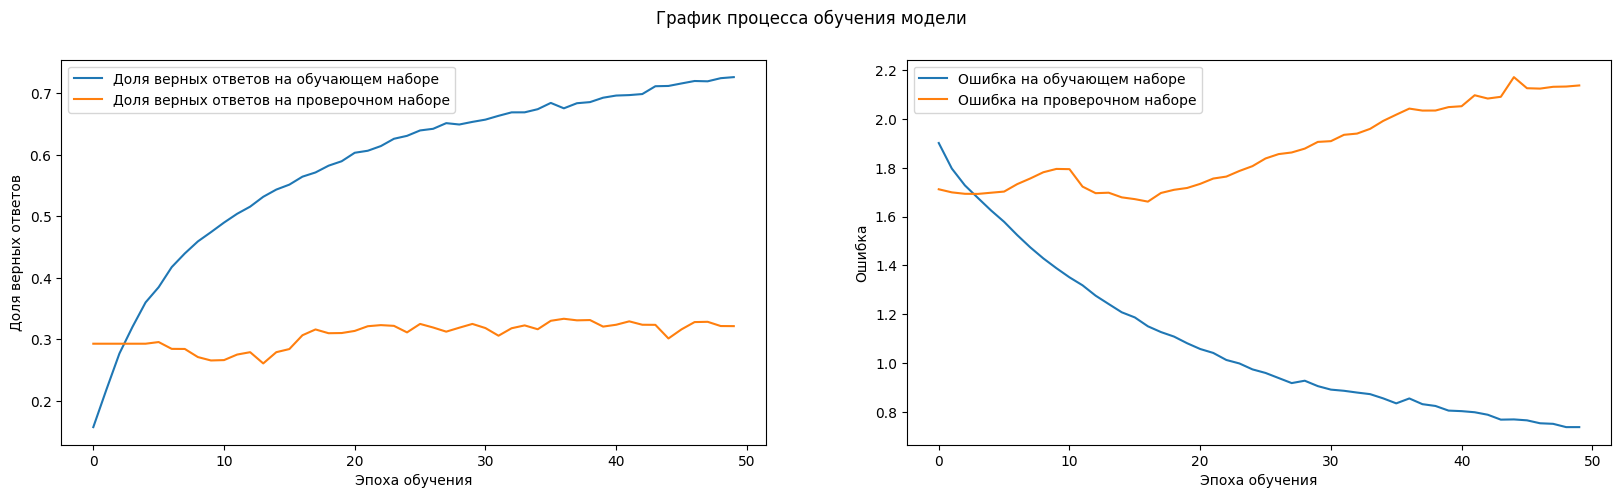

209/209 [==============================] - 17s 77ms/step


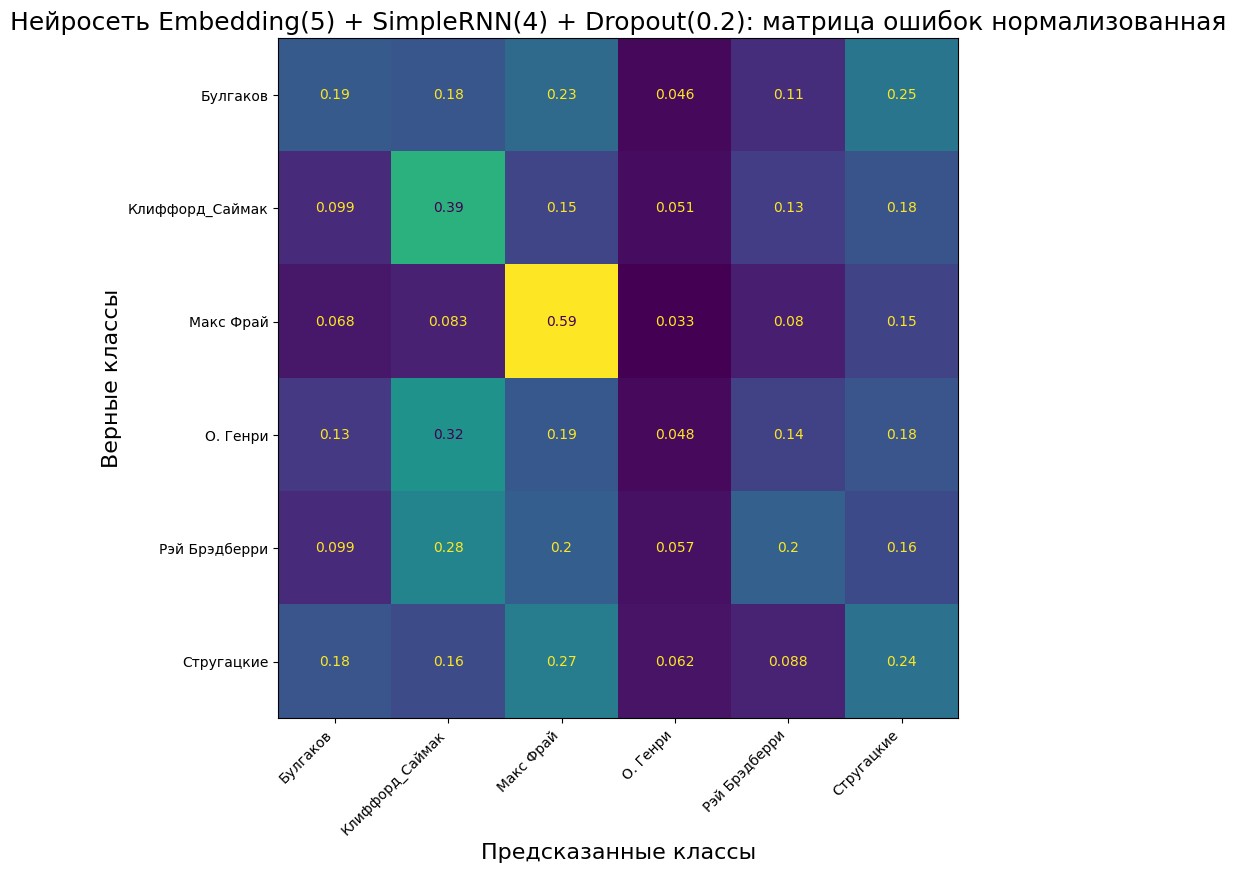

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding(5) + SimpleRNN(4) + Dropout(0.2)
Класс: Булгаков              25% сеть отнесла к классу Стругацкие           - НЕВЕРНО :-(
Класс: Клиффорд_Саймак       39% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Макс Фрай             59% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: О. Генри              32% сеть отнесла к классу Клиффорд_Саймак      - НЕВЕРНО :-(
Класс: Рэй Брэдберри         28% сеть отнесла к классу Клиффорд_Саймак      - НЕВЕРНО :-(
Класс: Стругацкие            27% сеть отнесла к классу Макс Фрай            - НЕВЕРНО :-(

Средняя точность распознавания:  28%


In [22]:
# Создание последовательной модели нейросети
model_SimpleRNN_1 = Sequential()

# Слой эмбеддинга преобразует каждое (индекс) в многомерный плотный вектор
# На входе указываются объем словаря, размерность вектора и длина входных данных
model_SimpleRNN_1.add(Embedding(VOCAB_SIZE, 5, input_length=WIN_SIZE))

# Слой регуляризации, "выключает" 1D карты объектов из эмбеддинг-векторов
model_SimpleRNN_1.add(SpatialDropout1D(0.2))
# Слой нормализации данных
model_SimpleRNN_1.add(BatchNormalization())
# Рекуррентный слой
model_SimpleRNN_1.add(SimpleRNN(4))
# Слой регуляризации Dropout для отдельных нейронов
model_SimpleRNN_1.add(Dropout(0.2))
# Выходной слой классификатора
model_SimpleRNN_1.add(Dense(CLASS_COUNT, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

compile_train_eval_model(model_SimpleRNN_1,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=50,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(5) + SimpleRNN(4) + Dropout(0.2)')

**Исследование №2: Embedding(5) + SimpleRNN(20) + Dropout(0.2)**

In [ ]:
# Создание последовательной модели нейросети
model_SimpleRNN_2 = Sequential()

# Слой эмбеддинга преобразует каждое (индекс) в многомерный плотный вектор
# На входе указываются объем словаря, размерность вектора и длина входных данных
model_SimpleRNN_2.add(Embedding(VOCAB_SIZE, 5, input_length=WIN_SIZE))

# Слой регуляризации, "выключает" 1D карты объектов из эмбеддинг-векторов
model_SimpleRNN_2.add(SpatialDropout1D(0.2))
# Слой нормализации данных
model_SimpleRNN_2.add(BatchNormalization())
# Рекуррентный слой
model_SimpleRNN_2.add(SimpleRNN(20))
# Слой регуляризации Dropout для отдельных нейронов
model_SimpleRNN_2.add(Dropout(0.2))
# Выходной слой классификатора
model_SimpleRNN_2.add(Dense(CLASS_COUNT, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

compile_train_eval_model(model_SimpleRNN_2,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=50,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(5) + SimpleRNN(20) + Dropout(0.2)')

**Исследование №3: Embedding(100) + SimpleRNN(20) + Dropout(0.2)**

In [ ]:
# Создание последовательной модели нейросети
model_SimpleRNN_3 = Sequential()

# Слой эмбеддинга преобразует каждое (индекс) в многомерный плотный вектор
# На входе указываются объем словаря, размерность вектора и длина входных данных
model_SimpleRNN_3.add(Embedding(VOCAB_SIZE, 100, input_length=WIN_SIZE))

# Слой регуляризации, "выключает" 1D карты объектов из эмбеддинг-векторов
model_SimpleRNN_3.add(SpatialDropout1D(0.2))
# Слой нормализации данных
model_SimpleRNN_3.add(BatchNormalization())
# Рекуррентный слой
model_SimpleRNN_3.add(SimpleRNN(20))
# Слой регуляризации Dropout для отдельных нейронов
model_SimpleRNN_3.add(Dropout(0.2))
# Выходной слой классификатора
model_SimpleRNN_3.add(Dense(CLASS_COUNT, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

compile_train_eval_model(model_SimpleRNN_3,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=50,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(100) + SimpleRNN(20) + Dropout(0.2)')

**Исследование №4: Embedding(5) + SimpleRNN(20) + Dropout(0.4)**

In [ ]:
# Создание последовательной модели нейросети
model_SimpleRNN_4 = Sequential()

# Слой эмбеддинга преобразует каждое (индекс) в многомерный плотный вектор
# На входе указываются объем словаря, размерность вектора и длина входных данных
model_SimpleRNN_4.add(Embedding(VOCAB_SIZE, 5, input_length=WIN_SIZE))

# Слой регуляризации, "выключает" 1D карты объектов из эмбеддинг-векторов
model_SimpleRNN_4.add(SpatialDropout1D(0.4))
# Слой нормализации данных
model_SimpleRNN_4.add(BatchNormalization())
# Рекуррентный слой
model_SimpleRNN_4.add(SimpleRNN(20))
# Слой регуляризации Dropout для отдельных нейронов
model_SimpleRNN_4.add(Dropout(0.4))
# Выходной слой классификатора
model_SimpleRNN_4.add(Dense(CLASS_COUNT, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

compile_train_eval_model(model_SimpleRNN_4,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=50,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(5) + SimpleRNN(20) + Dropout(0.2)')

### GRU

**Исследование №5: Embedding(5) + GRU(4/0.2) + Dropout(0.2)**

In [ ]:
model_GRU_1 = Sequential()
model_GRU_1.add(Embedding(VOCAB_SIZE, 5, input_length=WIN_SIZE))
model_GRU_1.add(SpatialDropout1D(0.2))
model_GRU_1.add(BatchNormalization())
# Рекуррентный слой GRU
model_GRU_1.add(GRU(4, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
model_GRU_1.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_GRU_1,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=50,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(5) + GRU(4/0.2) + Dropout(0.2)')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 5)           100000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 1000, 5)          0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_1 (Batc  (None, 1000, 5)          20        
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 4)                 132       
                                                                 
 dense_1 (Dense)             (None, 6)                 30        
                                                                 
Total params: 100,182
Trainable params: 100,172
Non-tr

None

Epoch 1/50
35/35 [==============================] - 97s 3s/step - loss: 1.7796 - accuracy: 0.2412 - val_loss: 1.7729 - val_accuracy: 0.2929
Epoch 2/50
35/35 [==============================] - 76s 2s/step - loss: 1.7221 - accuracy: 0.3188 - val_loss: 1.7570 - val_accuracy: 0.2929
Epoch 3/50
35/35 [==============================] - 103s 3s/step - loss: 1.6870 - accuracy: 0.3299 - val_loss: 1.7433 - val_accuracy: 0.2929
Epoch 4/50
35/35 [==============================] - 85s 2s/step - loss: 1.6575 - accuracy: 0.3394 - val_loss: 1.7347 - val_accuracy: 0.2929
Epoch 5/50
35/35 [==============================] - 99s 3s/step - loss: 1.6281 - accuracy: 0.3516 - val_loss: 1.7298 - val_accuracy: 0.2929
Epoch 6/50
35/35 [==============================] - 83s 2s/step - loss: 1.5977 - accuracy: 0.3671 - val_loss: 1.7283 - val_accuracy: 0.2929
Epoch 7/50
35/35 [==============================] - 80s 2s/step - loss: 1.5623 - accuracy: 0.3799 - val_loss: 1.7320 - val_accuracy: 0.2929
Epoch 8/50
35/35 [=

**Исследование №6: Embedding(5) + GRU(40/0.4) + Dropout(0.2)**

In [ ]:
model_GRU_2 = Sequential()
model_GRU_2.add(Embedding(VOCAB_SIZE, 5, input_length=WIN_SIZE))
model_GRU_2.add(SpatialDropout1D(0.2))
model_GRU_2.add(BatchNormalization())
# Рекуррентный слой GRU
model_GRU_2.add(GRU(40, dropout=0.4, recurrent_dropout=0.4, activation='relu'))
model_GRU_2.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_GRU_2,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=50,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(5) + GRU(40/0.4) + Dropout(0.2)')

**Исследование №7: Embedding(5) + GRU(80/0.2) + Dropout(0.2)**

In [ ]:
model_GRU_3 = Sequential()
model_GRU_3.add(Embedding(VOCAB_SIZE, 5, input_length=WIN_SIZE))
model_GRU_3.add(SpatialDropout1D(0.2))
model_GRU_3.add(BatchNormalization())
# Рекуррентный слой GRU
model_GRU_3.add(GRU(80, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
model_GRU_3.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_GRU_3,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=50,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(5) + GRU(80/0.2) + Dropout(0.2)')

### LSTM

**Исследование №8: Embedding(5) + LSTM(4) + Dropout(0.2)**

In [ ]:
model_LSTM_1 = Sequential()
model_LSTM_1.add(Embedding(VOCAB_SIZE, 5, input_length=WIN_SIZE))
model_LSTM_1.add(SpatialDropout1D(0.2))
model_LSTM_1.add(BatchNormalization())
# Рекуррентный слой LSTM
model_LSTM_1.add(LSTM(4))
model_LSTM_1.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_LSTM_1,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(5) + LSTM(4) + Dropout(0.2)')

**Исследование №9: Embedding(5) + LSTM(20) + Dropout(0.2)**

In [ ]:
model_LSTM_2 = Sequential() # создаём последовательную модель нейросети
model_LSTM_2.add(Embedding(VOCAB_SIZE, 5, input_length=WIN_SIZE))
model_LSTM_2.add(SpatialDropout1D(0.2))
model_LSTM_2.add(BatchNormalization())
# Рекуррентный слой LSTM
model_LSTM_2.add(LSTM(20))
model_LSTM_2.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_LSTM_2,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(5) + LSTM(20) + Dropout(0.2)')

**Исследование №10: Embedding(5) + LSTM(100) + Dropout(0.2)**

In [ ]:
model_LSTM_3 = Sequential()
model_LSTM_3.add(Embedding(VOCAB_SIZE, 5, input_length=WIN_SIZE))
model_LSTM_3.add(SpatialDropout1D(0.2))
model_LSTM_3.add(BatchNormalization())
# Рекуррентный слой LSTM
model_LSTM_3.add(LSTM(100))
model_LSTM_3.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_LSTM_3,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(5) + LSTM(100) + Dropout(0.2)')

**Исследование №11: Embedding(5) + LSTM(4)x2 + Dropout(0.2)**

In [ ]:
model_LSTM_4 = Sequential()
model_LSTM_4.add(Embedding(VOCAB_SIZE, 5, input_length=WIN_SIZE))
model_LSTM_4.add(SpatialDropout1D(0.2))
model_LSTM_4.add(BatchNormalization())
# Два рекуррентных слоя LSTM
model_LSTM_4.add(LSTM(4, return_sequences=True))
model_LSTM_4.add(LSTM(4))
model_LSTM_4.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_LSTM_4,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(5) + LSTM(4)x2 + Dropout(0.2)')

**Исследование №12: Embedding(200) + LSTM(4)x2 + Dropout(0.2)**

In [ ]:
model_LSTM_5 = Sequential()
model_LSTM_5.add(Embedding(VOCAB_SIZE, 200, input_length=WIN_SIZE))
model_LSTM_5.add(SpatialDropout1D(0.2))
model_LSTM_5.add(BatchNormalization())
# Два рекуррентных слоя LSTM
model_LSTM_5.add(LSTM(4, return_sequences=True))
model_LSTM_5.add(LSTM(4))
model_LSTM_5.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_LSTM_5,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(200) + LSTM(4)x2 + Dropout(0.2)')

**Исследование №13: Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)**

In [ ]:
model_LSTM_6 = Sequential()
model_LSTM_6.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
model_LSTM_6.add(SpatialDropout1D(0.4))
model_LSTM_6.add(BatchNormalization())
# Два двунаправленных рекуррентных слоя LSTM
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())
# Два рекуррентных слоя GRU
model_LSTM_6.add(GRU(16, return_sequences=True, reset_after=True))
model_LSTM_6.add(GRU(16, reset_after=True))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())
# Дополнительный полносвязный слой
model_LSTM_6.add(Dense(200, activation='relu'))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())
model_LSTM_6.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_LSTM_6,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)')

**Исследование №14: Embedding(50) + BLSTM(8)x2 + Dropout(0.4, 0.3)**

In [ ]:
model_LSTM_7 = Sequential()
model_LSTM_7.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
model_LSTM_7.add(SpatialDropout1D(0.4))
model_LSTM_7.add(BatchNormalization())
# Два двунаправленных рекуррентных слоя LSTM
model_LSTM_7.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_7.add(Bidirectional(LSTM(8)))
model_LSTM_7.add(Dropout(0.3))
model_LSTM_7.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_LSTM_7,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(50) + BLSTM(8)x2 + Dropout(0.4, 0.3)')

### Conv1D

**Исследование №17: Conv1D №1**

In [ ]:
model_Conv_1 = Sequential()
model_Conv_1.add(Embedding(VOCAB_SIZE, 10, input_length=WIN_SIZE))
model_Conv_1.add(SpatialDropout1D(0.2))
model_Conv_1.add(BatchNormalization())
# Два слоя одномерной свертки Conv1D
model_Conv_1.add(Conv1D(20, 5, activation='relu', padding='same'))
model_Conv_1.add(Conv1D(20, 5, activation='relu'))
# Слой подвыборки/пулинга с функцией максимума
model_Conv_1.add(MaxPooling1D(2))
model_Conv_1.add(Dropout(0.2))
model_Conv_1.add(BatchNormalization())
model_Conv_1.add(Flatten())
model_Conv_1.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_Conv_1,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=200,
                         class_labels=CLASS_LIST,
                         title='Conv1D №1')

**Исследование №18: Conv1D №2**

In [ ]:
model_Conv_2 = Sequential()
model_Conv_2.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
model_Conv_2.add(SpatialDropout1D(0.2))
model_Conv_2.add(BatchNormalization())
# Два слоя одномерной свертки Conv1D
model_Conv_2.add(Conv1D(20, 5, activation='relu', padding='same'))
model_Conv_2.add(Conv1D(20, 5, activation='relu', padding='same'))
# Слой подвыборки/пулинга с функцией максимума
model_Conv_2.add(MaxPooling1D(2))
model_Conv_2.add(Dropout(0.2))
model_Conv_2.add(BatchNormalization())
# Слой глобального пулинга с функцией максимума
model_Conv_2.add(GlobalMaxPooling1D())
model_Conv_2.add(Dense(20, activation='relu'))
model_Conv_2.add(Dropout(0.2))
model_Conv_2.add(BatchNormalization())
model_Conv_2.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_Conv_2,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=200,
                         class_labels=CLASS_LIST,
                         title='Conv1D №2')

**Исследование №19: Conv1D №3**

In [ ]:
model_Conv_3 = Sequential()
model_Conv_3.add(Embedding(VOCAB_SIZE, 10, input_length=WIN_SIZE))
model_Conv_3.add(SpatialDropout1D(0.2))
model_Conv_3.add(BatchNormalization())
# Два слоя одномерной свертки Conv1D
model_Conv_3.add(Conv1D(20, 5, activation='relu'))
model_Conv_3.add(Conv1D(20, 5, activation='relu'))
# Слой подвыборки/пулинга с функцией максимума
model_Conv_3.add(MaxPooling1D(2))
model_Conv_3.add(Dropout(0.2))
model_Conv_3.add(BatchNormalization())
# Два слоя одномерной свертки Conv1D
model_Conv_3.add(Conv1D(20, 5, activation='relu'))
model_Conv_3.add(Conv1D(20, 5, activation='relu'))
# Слой подвыборки/пулинга с функцией максимума
model_Conv_3.add(MaxPooling1D(2))
model_Conv_3.add(Dropout(0.2))
model_Conv_3.add(BatchNormalization())
# Два слоя одномерной свертки Conv1D
model_Conv_3.add(Conv1D(20, 5, activation='relu'))
model_Conv_3.add(Conv1D(20, 5, activation='relu'))
# Слой подвыборки/пулинга с функцией максимума
model_Conv_3.add(MaxPooling1D(2))
model_Conv_3.add(Dropout(0.2))
model_Conv_3.add(BatchNormalization())
# Слой выравнивания/сглаживания ("сплющивание" данных в вектор)
model_Conv_3.add(Flatten())
model_Conv_3.add(Dense(64, activation='relu'))
model_Conv_3.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_Conv_3,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=200,
                         class_labels=CLASS_LIST,
                         title='Conv1D №3')

**Исследование №20: Conv1D №4**

In [ ]:
model_Conv_4 = Sequential()
model_Conv_4.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
model_Conv_4.add(SpatialDropout1D(0.2))
model_Conv_4.add(BatchNormalization())
# Слой одномерной свертки Conv1D
model_Conv_4.add(Conv1D(20, 5, activation='relu'))
# Слой подвыборки/пулинга с функцией максимума
model_Conv_4.add(MaxPooling1D(2))
model_Conv_4.add(Dropout(0.2))
model_Conv_4.add(BatchNormalization())
# Слой глобального пулинга с функцией максимума
model_Conv_4.add(GlobalMaxPooling1D())
# Дополнительный полносвязный слой
model_Conv_4.add(Dense(20, activation='relu'))
model_Conv_4.add(Dropout(0.2))
model_Conv_4.add(BatchNormalization())
model_Conv_4.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_Conv_4,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=200,
                         class_labels=CLASS_LIST,
                         title='Conv1D №4')

### LSTM + Conv1D

**Исследование №21: LSTM + Conv1D №1**

In [ ]:
model_LC_1 = Sequential()
model_LC_1.add(Embedding(VOCAB_SIZE, 10, input_length=WIN_SIZE))
model_LC_1.add(SpatialDropout1D(0.2))
# Рекуррентный слой LSTM
model_LC_1.add(LSTM(4, return_sequences=1))
# Полносвязный слой
model_LC_1.add(Dense(100, activation='relu'))
# Сверточный слой
model_LC_1.add(Conv1D(20, 5, activation='relu'))
# Рекуррентный слой LSTM
model_LC_1.add(LSTM(4, return_sequences=1))
# Слой регуляризации Dropout
model_LC_1.add(Dropout(0.2))
# Слой пакетной нормализации
model_LC_1.add(BatchNormalization())
# Два сверточных слоя
model_LC_1.add(Conv1D(20, 5, activation='relu'))
model_LC_1.add(Conv1D(20, 5, activation='relu'))
# Слой подвыборки/пулинга с функцией максимума
model_LC_1.add(MaxPooling1D(2))
model_LC_1.add(Dropout(0.2))
model_LC_1.add(BatchNormalization())
# Слой выравнивания/сглаживания ("сплющивание" данных в вектор)
model_LC_1.add(Flatten())
model_LC_1.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_LC_1,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=200,
                         class_labels=CLASS_LIST,
                         title='LSTM + Conv1D №1')

**Исследование №22: LSTM + Conv1D №2**

In [ ]:
model_LC_2 = Sequential()
model_LC_2.add(Embedding(VOCAB_SIZE, 10, input_length=WIN_SIZE))
model_LC_2.add(SpatialDropout1D(0.2))
# Рекуррентный слой LSTM
model_LC_2.add(LSTM(4, return_sequences=1))
# Полносвязный слой
model_LC_2.add(Dense(100, activation='relu'))
# Сверточный слой
model_LC_2.add(Conv1D(20, 5, activation='relu'))
# Рекуррентный слой LSTM
model_LC_2.add(LSTM(4, return_sequences=1))
# Слой подвыборки/пулинга с функцией максимума
model_LC_2.add(MaxPooling1D(2))
model_LC_2.add(Dropout(0.2))
model_LC_2.add(BatchNormalization())
# Слой выравнивания/сглаживания ("сплющивание" данных в вектор)
model_LC_2.add(Flatten())
model_LC_2.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_LC_2,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=200,
                         class_labels=CLASS_LIST,
                         title='LSTM + Conv1D №2')

**Исследование №23: LSTM + Conv1D №3**

In [ ]:
model_LC_3 = Sequential()
model_LC_3.add(Embedding(VOCAB_SIZE, 10, input_length=WIN_SIZE))
model_LC_3.add(SpatialDropout1D(0.2))
# Сверточный слой
model_LC_3.add(Conv1D(20, 5, activation='relu'))
# Слой подвыборки/пулинга с функцией максимума
model_LC_3.add(MaxPooling1D(2))
# Слой регуляризации Dropout
model_LC_3.add(Dropout(0.2))
# Слой пакетной нормализации
model_LC_3.add(BatchNormalization())
# Рекуррентный слой LSTM
model_LC_3.add(LSTM(4, return_sequences=1))
model_LC_3.add(Dropout(0.2))
model_LC_3.add(BatchNormalization())
# Слой выравнивания/сглаживания ("сплющивание" данных в вектор)
model_LC_3.add(Flatten())
model_LC_3.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_LC_3,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=200,
                         class_labels=CLASS_LIST,
                         title='LSTM + Conv1D №3')